# 目的正味重量分布の予測

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

import pymc as pm

In [2]:
def get_data(db_file='../data/choco-ball.db', table_name='measurement'):
    """
    dbファイルから計測データを取得する
    
    TODO:
        エラー処理を入れる
    """
    con = sqlite3.connect(db_file)
    sql = 'SELECT '
    sql += 'measure_date,best_before,weight,box_weight,ball_number,factory,shop,angel '
    sql += ', (weight - box_weight), (weight - box_weight)/ball_number '
    sql += 'FROM ' + table_name
    sql += ';'
    sql_result = con.execute(sql)
    res = sql_result.fetchall()
    con.close()
    data = pd.DataFrame(res, columns=['measure_date','best_before','weight','box_weight','ball_number','factory','shop','angel', 'net_weight', 'mean_weight'])
    print 'Shape of MeasurementData(record_num, n_columns) : {}'.format(data.shape)
    return data

def get_date_str():
    tdatetime = dt.now()
    tstr = tdatetime.strftime('%Y-%m-%d')
    return tstr

Shape of MeasurementData(record_num, n_columns) : (15, 10)


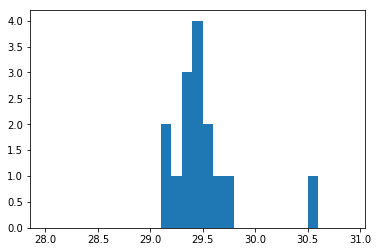

In [3]:
data = get_data()
ret = plt.hist(data['net_weight'], bins=np.arange(28.0, 31.0, 0.1))

In [4]:
# 最尤推定量
## 正規分布を仮定
m = data['net_weight'].mean()
s = data['net_weight'].std()
print 'mean:{}, std:{}'.format(m, s)

mean:29.4978666667, std:0.322963259004


In [5]:
# 精度$\tau$(分散の逆数)
tau = 1.0 / pm.Uniform("std", 0, 100)**2
# 分布の中心
## 事前分布の中心として、製品仕様の28を、tauを0.01(分散=100)
center = pm.Normal("center", 28, 0.01)

# 観測とモデルを結びつける
observations = pm.Normal("obs", center, tau, value=data['net_weight'].values, observed=True)

# Modelオブジェクト生成
model = pm.Model([tau, center])

In [6]:
mcmc = pm.MCMC(model)
mcmc.sample(30000, 10000)

 [-----------------100%-----------------] 30000 of 30000 complete in 2.3 sec

In [7]:
center_trace = mcmc.trace("center")[:]
std_trace = mcmc.trace("std")[:]


esetimate_center : 29.4993064588


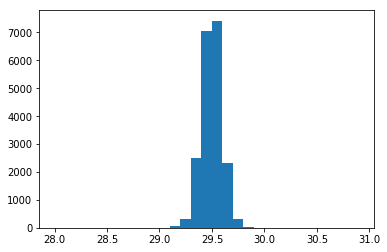

In [8]:
ret = plt.hist(center_trace, bins=np.arange(28.0, 31.0, 0.1))
print 'esetimate_center : {}'.format(center_trace.mean())

estimate_std : 0.355042372385


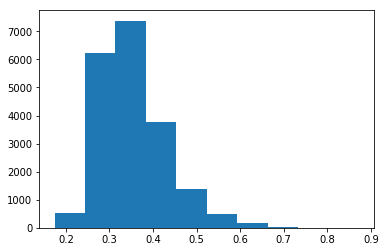

In [9]:
ret = plt.hist(std_trace)
print 'estimate_std : {}'.format(std_trace.mean())

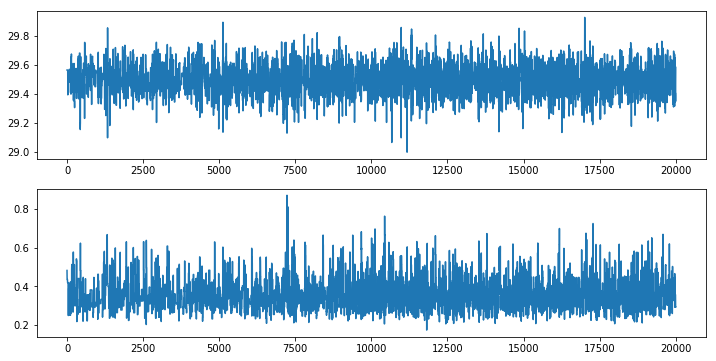

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(center_trace, label="center_trace")

plt.subplot(2,1,2)
plt.plot(std_trace, label="center_trace")
